# Project 2

The group project is split into 5 tasks. I've already finished the first one, which consists of creating some example pictures of cut out words manually. I've put these examplewords into the folder perpared_words and load them into the variable prepared_words_images so they can be used for the other tasks.

All the tasks are built up in such a way, that nobody has to wait on the other people to finish their task. (Except for the last part of task 4)

## Task 0: Creating and loading testimages
Create some test images and load them here so they can be used for task 1 and 2

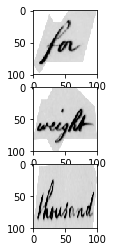

In [35]:
import numpy as np
import os

from PIL import Image
def load_images(data_root, image_paths, target_size):
    images = []
    for img_path in image_paths:
        path = os.path.join(data_root, img_path)
        img = Image.open(path)
        img = img.convert('RGB')
        img = img.resize(target_size)
        images.append(np.array(img)) 
    return images

prepared_words_dir = 'prepared_words'
prepared_words_paths = os.listdir(prepared_words_dir)

target_size = (100, 100)

prepared_words_images = load_images(prepared_words_dir, prepared_words_paths, target_size)
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(len(prepared_words_images)):
    plt.subplot(3, 1, i+1)
    plt.imshow(prepared_words_images[i])

## Task 1: Dynamic Time Wrapping
Create a method that calculates the distance between two word using Dynamic Time Wrapping. You can use the words in prepared_words_images for testing your method.

In [36]:
import random

def dynamicTimeWrapping(img1, img2):
    return random.randint(1,101)

## Task 2: Train and Apply
Write a Class that can be fed multiple pictures. It should then be able to classify a new picture using the dynamicTimeWrapping method above. You can already use the current dynamicTimeWrapping function (which currently just returns random results).
You can use the words in prepared_words_images for testing your class.

In [43]:
class WordClassifier:
    def train(words):
        # Todo: safe the words. Sync up with with
        print('training the model')
    def classify(word):
        # Classify a word
        return 'a_word'

## Task 3: Split up the jpg pages into individual pictures of words
Write an algorithm that turns a given page in the images folder into pictures of individual words using the svg file from the ground-truth folder. Currently it just returns the words from prepared_words_images so the people from the other tasks can already use it.

In [41]:
def loadWordsFromPage(page):
    return prepared_words_images

## Task 4:  Combine all above tasks
Use the class and methods above to train and apply our classifier. Maybe write something about accuracy and stuff once the other people have finished their part. Check the exercise hour pdf and https://github.com/lunactic/PatRec17_KWS_Data for more info.